In [ ]:
import torch
from google.colab import drive

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
drive.mount('/content/drive')

Using device: cuda
Mounted at /content/drive


# Load Dataset

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

BATCH_SZ = 512
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SZ, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SZ, shuffle=False)

x_sample, y_sample = next(iter(train_loader))
print()
print(f"Batch Shape: {tuple(x_sample.shape)}")
print(f"Label Shape: {tuple(y_sample.shape)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 531kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.64MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.02MB/s]



Batch Shape: (512, 1, 28, 28)
Label Shape: (512,)


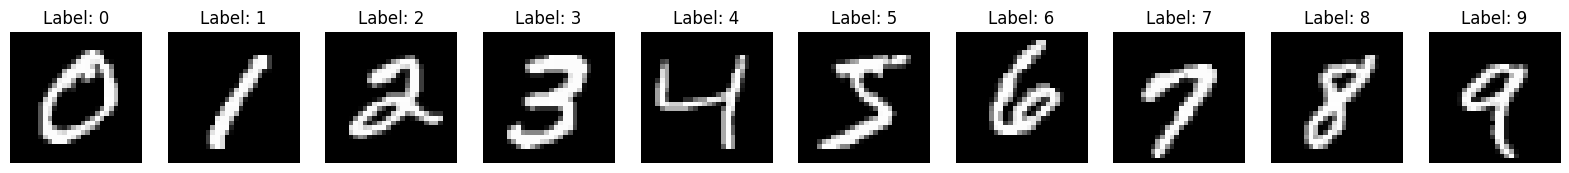

In [ ]:
import matplotlib.pyplot as plt


images_to_plot = {}
for img, label in train_dataset:
  if label not in images_to_plot: images_to_plot[label] = img
  if len(images_to_plot) == 10: break

fig, axes = plt.subplots(1, len(images_to_plot), figsize=(20, 4))
for i, ax in enumerate(axes):
  ax.imshow(images_to_plot[i].squeeze(), cmap="gray")
  ax.set_title(f"Label: {i}")
  ax.axis("off")
plt.show()

# The NN

In [ ]:
import torch.nn as nn

model = nn.Sequential(
  nn.Conv2d(1, 32, 3), nn.ReLU(), nn.MaxPool2d(2, 2),
  nn.Flatten(),
  nn.Linear(32 * 13 * 13, 64), nn.ReLU(),
  nn.Dropout(0.25),
  nn.Linear(64, 10)
).to(device)
print(model)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=5408, out_features=64, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.25, inplace=False)
  (7): Linear(in_features=64, out_features=10, bias=True)
)


Epoch 1/50, Loss: 0.6480, Accuracy: 81.57%
Epoch 2/50, Loss: 0.2267, Accuracy: 93.44%
Epoch 3/50, Loss: 0.1577, Accuracy: 95.50%
Epoch 4/50, Loss: 0.1249, Accuracy: 96.41%
Epoch 5/50, Loss: 0.1051, Accuracy: 97.00%
Epoch 6/50, Loss: 0.0884, Accuracy: 97.44%
Epoch 7/50, Loss: 0.0783, Accuracy: 97.71%
Epoch 8/50, Loss: 0.0709, Accuracy: 97.92%
Epoch 9/50, Loss: 0.0644, Accuracy: 98.11%
Epoch 10/50, Loss: 0.0602, Accuracy: 98.21%
Epoch 11/50, Loss: 0.0547, Accuracy: 98.37%
Epoch 12/50, Loss: 0.0518, Accuracy: 98.39%
Epoch 13/50, Loss: 0.0484, Accuracy: 98.55%
Epoch 14/50, Loss: 0.0446, Accuracy: 98.61%
Epoch 15/50, Loss: 0.0417, Accuracy: 98.69%
Epoch 16/50, Loss: 0.0395, Accuracy: 98.76%
Epoch 17/50, Loss: 0.0371, Accuracy: 98.83%
Epoch 18/50, Loss: 0.0360, Accuracy: 98.88%
Epoch 19/50, Loss: 0.0345, Accuracy: 98.92%
Epoch 20/50, Loss: 0.0314, Accuracy: 99.05%
Epoch 21/50, Loss: 0.0293, Accuracy: 99.06%
Epoch 22/50, Loss: 0.0282, Accuracy: 99.13%
Epoch 23/50, Loss: 0.0281, Accuracy: 99.0

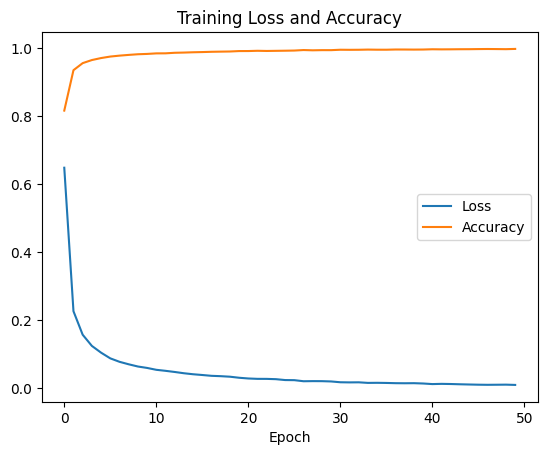

In [ ]:
import torch.optim as optim
import time


EPOCHS = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_history = []
acc_history = []

model.train()
start_time = time.time()
for epoch in range(EPOCHS):
  running_loss = 0.0
  correct = 0
  total = 0

  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  epoch_acc = correct / total
  epoch_loss = running_loss / len(train_loader)
  loss_history.append(epoch_loss)
  acc_history.append(epoch_acc)
  print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc*100:.2f}%")
  if epoch_loss < 0.001: break

if device.type == 'cuda': torch.cuda.synchronize()
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

plt.plot(loss_history, label='Loss')
plt.plot(acc_history, label='Accuracy')
plt.xlabel('Epoch')
plt.title('Training Loss and Accuracy')
plt.legend()
plt.show()

In [ ]:
import numpy as np


all_preds = []
all_labels = []
all_probs = []
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    probs = nn.functional.softmax(outputs, dim=1)
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    all_preds.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
    all_probs.extend(probs.cpu().numpy())

print(f"Test Accuracy: {correct / total * 100:.2f}%")
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

Test Accuracy: 98.65%


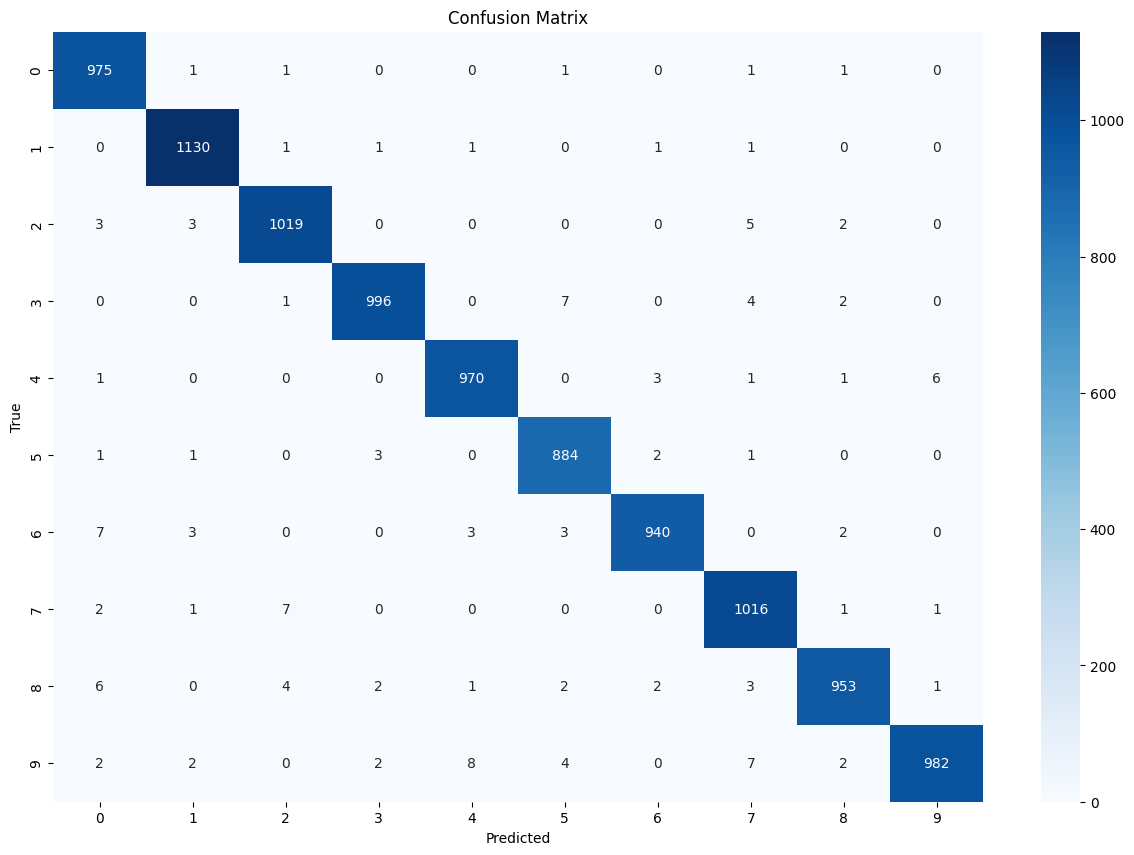

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_mat = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(confusion_mat, annot=True, fmt='d', ax=ax, cmap="Blues")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

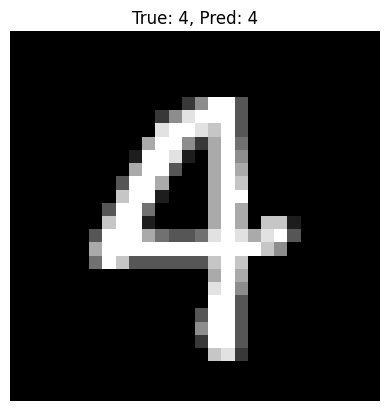

In [ ]:
indices = np.random.choice(len(test_dataset))
x_sample_img, y_sample_true = test_dataset[indices]
y_sample_pred = all_preds[indices]

plt.title(f"True: {y_sample_true}, Pred: {y_sample_pred}")
plt.imshow(x_sample_img.squeeze(), cmap="gray")
plt.axis('off')
plt.show()

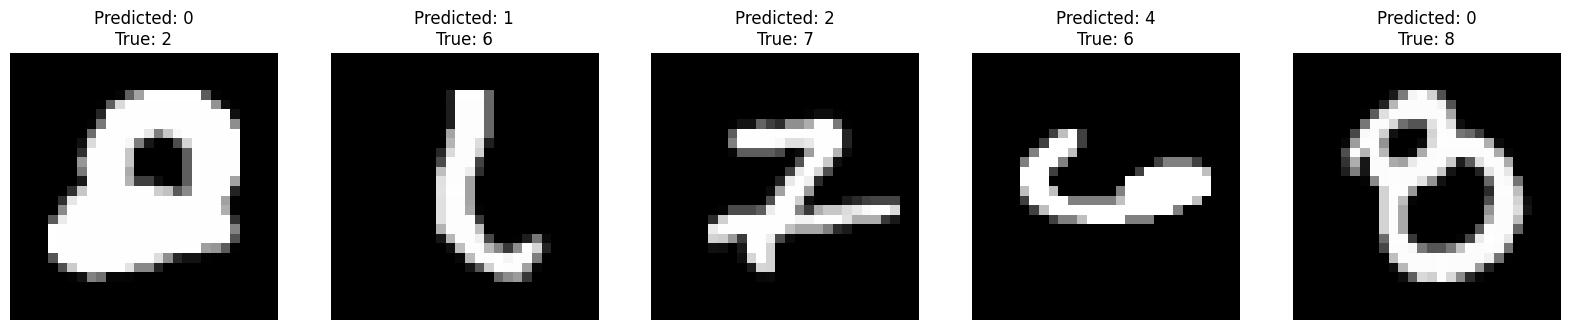

In [ ]:
errors = (all_preds != all_labels)
error_preds = all_preds[errors]
error_probs = all_probs[errors]
error_labels = all_labels[errors]
error_tests = test_dataset.data[errors]

error_pred_probs = np.max(error_probs, axis=1)
error_label_probs = np.diagonal(np.take(error_probs, error_labels, axis=1))
diffs = error_pred_probs - error_label_probs
top_indices = np.argsort(diffs)[-5:]

f, axes = plt.subplots(1, len(top_indices), figsize=(20, 20))
for idx, ax in zip(top_indices, axes):
  sample = error_tests[idx].squeeze()
  ax.imshow(sample, cmap='gray')
  ax.set_title(f"Predicted: {error_preds[idx]}\nTrue: {error_labels[idx]}")
  ax.axis('off')
plt.show()

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/MNIST_Model.pth')

# Demo

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/MNIST_Model.pth', map_location=device))
model.eval()

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=5408, out_features=64, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.25, inplace=False)
  (7): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
import cv2


class GradCAM:
  def save_feature_maps(self, module, input, output): self.feature_maps = output
  def save_gradients(self, module, grad_input, grad_output): self.gradients = grad_output[0]

  def __init__(self):
    self.feature_maps = None
    self.gradients = None
    last_conv = model[0]
    last_conv.register_forward_hook(self.save_feature_maps)
    last_conv.register_full_backward_hook(self.save_gradients)

  def generate_cam(self, input_tensor):
    output = model(input_tensor)
    target_class = output.argmax(dim=1).item()

    model.zero_grad()
    output[0][target_class].backward()

    activations = self.feature_maps[0]
    weights = torch.mean(self.gradients[0], dim=(1, 2))
    cam = (weights[:, None, None] * activations).sum(dim=0)
    cam = torch.relu(cam)

    cam = cam.cpu().detach().numpy()
    cam = cv2.resize(cam, (28, 28))
    cam = cv2.normalize(cam, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return cam

grad_cam = GradCAM()

Output()


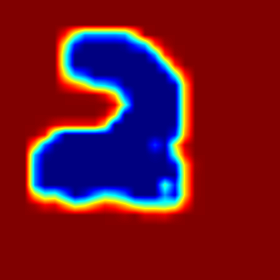


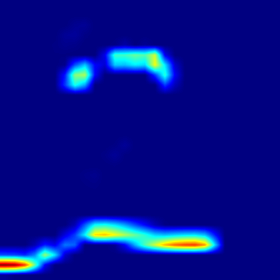


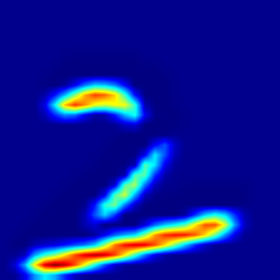

In [ ]:
import base64
import io
from PIL import Image
from io import BytesIO
from IPython.display import display, HTML, clear_output
from google.colab import output
import ipywidgets as widgets


plot_output = widgets.Output()
def predict_merged(data_url):
  header, encoded = data_url.split(",", 1)
  image_pil = Image.open(BytesIO(base64.b64decode(encoded))).convert("L").resize((28, 28))

  img_array = np.array(image_pil)
  input_tensor = torch.tensor(img_array, dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 255.0
  input_tensor = input_tensor.to(next(model.parameters()).device)
  input_tensor.requires_grad = True

  heatmap = grad_cam.generate_cam(input_tensor)

  with torch.no_grad():
    conv1_out = nn.functional.relu(model[0](input_tensor))
    probabilities = nn.functional.softmax(model(input_tensor), dim=1)
    prediction = torch.argmax(probabilities, dim=1).item()
    confidence = probabilities[0][prediction].item() * 100

  heatmap_resized = cv2.resize(heatmap, (280, 280))
  heatmap_uint8 = np.uint8(255 * heatmap_resized)
  heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
  _, buffer = cv2.imencode('.png', heatmap_color)
  gradcam_b64 = "data:image/png;base64," + base64.b64encode(buffer).decode('utf-8')
  js_code = f"""
document.getElementById('prediction_text').innerText = "{prediction}";
document.getElementById('confidence_text').innerText = "{confidence:.2f}% confidence";
document.getElementById('gradcam_img').src = "{gradcam_b64}";
  """
  display(HTML(f"<script>{js_code}</script>"))

  with plot_output:
    clear_output(wait=True)
    feature_maps = conv1_out.squeeze(0).cpu().numpy()

    fig, axes = plt.subplots(2, 16, figsize=(20, 3))
    fig.suptitle(f'Feature Maps')

    for i, ax in enumerate(axes.flat):
      ax.imshow(feature_maps[i], cmap='viridis')
      ax.axis('off')
    plt.show()

output.register_callback('notebook.PredictMerged', predict_merged)

html_layout = """
<div style="font-family: sans-serif; display: flex; flex-direction: column; align-items: center; gap: 20px;">
    <div style="display: flex; gap: 40px; justify-content: center; flex-wrap: wrap;">
        <div style="text-align: center;">
            <h3>Draw Board</h3>
            <canvas id="draw_canvas" width="280" height="280" style="border: 2px solid #333; background: black; cursor: crosshair; touch-action: none;"></canvas>
            <div style="margin-top: 10px;">
                <button id="predict_btn" style="padding: 8px 16px; background-color: #4CAF50; color: white; border: none; border-radius: 4px; cursor: pointer; font-size: 14px;">Predict</button>
                <button id="clear_btn" style="padding: 8px 16px; background-color: #f44336; color: white; border: none; border-radius: 4px; cursor: pointer; font-size: 14px;">Clear</button>
            </div>
        </div>

        <div style="text-align: center;">
            <h3>Grad-CAM Board</h3>
            <img id="gradcam_img" width="280" height="280" style="border: 2px solid #ccc; background-color: #f0f0f0;" />
            <div style="margin-top: 15px; text-align: left; background: #eee; padding: 10px; border-radius: 5px; width: 280px;">
                <div>Prediction: <strong id="prediction_text" style="font-size: 1.5em; color: #333;">-</strong></div>
                <div>Confidence: <span id="confidence_text" style="color: #555;">-</span></div>
            </div>
        </div>
    </div>
</div>

<script>
    var canvas = document.getElementById('draw_canvas');
    var ctx = canvas.getContext('2d');
    var drawing = false;

    // Canvas Styles
    ctx.strokeStyle = "white";
    ctx.lineWidth = 20;
    ctx.lineCap = 'round';

    // Mouse Events
    canvas.addEventListener('mousedown', (e) => { drawing = true; ctx.beginPath(); draw(e); });
    canvas.addEventListener('mouseup', () => { drawing = false; });
    canvas.addEventListener('mousemove', draw);

    // Touch Events
    canvas.addEventListener('touchstart', (e) => {
        e.preventDefault(); drawing = true; ctx.beginPath();
        var touch = e.touches[0];
        var mouseEvent = new MouseEvent("mousedown", {clientX: touch.clientX, clientY: touch.clientY});
        canvas.dispatchEvent(mouseEvent);
    });
    canvas.addEventListener('touchend', (e) => { e.preventDefault(); drawing = false; });
    canvas.addEventListener('touchmove', (e) => {
        e.preventDefault();
        var touch = e.touches[0];
        var mouseEvent = new MouseEvent("mousemove", {clientX: touch.clientX, clientY: touch.clientY});
        canvas.dispatchEvent(mouseEvent);
    });

    function draw(e) {
        if (!drawing) return;
        var rect = canvas.getBoundingClientRect();
        ctx.lineTo(e.clientX - rect.left, e.clientY - rect.top);
        ctx.stroke();
        ctx.beginPath();
        ctx.moveTo(e.clientX - rect.left, e.clientY - rect.top);
    }

    document.getElementById('clear_btn').addEventListener('click', () => {
        ctx.clearRect(0, 0, canvas.width, canvas.height);
        document.getElementById('prediction_text').innerText = "-";
        document.getElementById('confidence_text').innerText = "-";
        document.getElementById('gradcam_img').src = "";
    });

    document.getElementById('predict_btn').addEventListener('click', () => {
        var dataUrl = canvas.toDataURL('image/png');
        document.getElementById('confidence_text').innerText = "Analyzing...";
        google.colab.kernel.invokeFunction('notebook.PredictMerged', [dataUrl], {});
    });
</script>
"""
display(HTML(html_layout))
display(plot_output)